In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace #this is used for debugging
np.random.seed(1234) 

## Naive Bayes for Document Classification
We want to use Naive Bayes with Bernoulli likelihood to classify text documents.
The dataset we will work with is the [20newsgroup](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset. The task is to classify a given document under one of different news categories. We will use four recreation categories `'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'`.

The first step is preprocessing the data to get a **bag of words** representation of documents. For this we will follow the [`scikit-learn` tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html). In this representation, we have a large sparse matrix, where each row is a document and each column is a word in the vocabulary. The vocabulary consists of all the words that appear in our documents. Since we want to use Bernoulli likelihood, we want each element of this matrix to be either zero or one, indicating the presence of a particular word in each document. 

Note that a better alternative (not used here) is to count the number of times a word appears in a document, and adjust these word counts based on the length of documents and frequencies of each word across documents (see explanation of *Term Frequency times Inverse Document Frequency*, TF-IDF in the `scikit-learn` tutorial).

The first time you run the code below it will take some time to load the dataset.

In [2]:
from sklearn.datasets import fetch_20newsgroups
categories = ['rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
data_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=123) #this dataset is in the form a dictionary
#print(data_train.keys())
#print(data_train['data']) # data is a "list" of text documents

Next, we need to *tokenize* documents, by assigning an integer ID to the words. Tokenizer uses white space and punctuation to identify different words. This is followed by counting the frequency of tokens per document. `CountVectorizer` function below performs both of these steps, and produces a [`sparse` matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html). There are different ways to represent matrices that have few non-zero values; for example we can store the index and the value of non-zeros, or alternatively the index-value of non-zero columns in each row. Each format is more suitable for certain operations. In the following we convert this sparse matrix to a dense matrix to simplify our implementation. However, note that for large documents and vocabularies we need to work with the sparse matrix. In the code below the design matrix `X_train` is the bag-of-word for the training data, and `Y_train` is the corresponding vector of labels. 

design matrix has 2389 rows (documents) and 30446 columns (words)


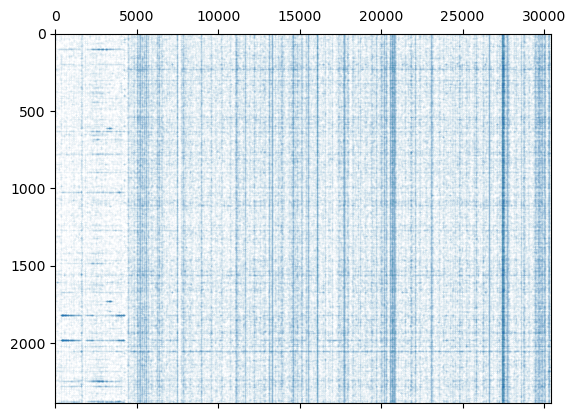

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(data_train.data)
print(f'design matrix has {counts.shape[0]} rows (documents) and {counts.shape[1]} columns (words)')
counts.data[:] = 1 #we only care about the presence/absence rather than the actual count, we are setting all non-zero entries to 1
plt.spy(counts, markersize=.01, aspect='auto') #visualizing the design matrix, as you see below it is quite sparse
X_train = np.array(counts.todense()) # turns the sparse matrix to a dense Numpy matrix. We then turn this matrix into an array format, which is more flexible for indexing purposes
Y_train = data_train.target

Now we are ready to write a Bernoulli Naive Bayes class for multi-class classification. 
Our class has a `fit` method that receives the input training data and sets model parameters. Then we have the `predict` method that uses the learned model parameter to produce class probabilities for a given input. Also our implementation for estimation of `mu` is using **add-one smoothing**. Our code estimates the prior `self.pi` and the class conditional likelihood for each word (features) `self.mu`.

In [4]:
from sklearn.preprocessing import OneHotEncoder #in case you need to use one-hot encoding of the labels
from scipy.special import logsumexp

def onehot(x, C=None): 
    # input x: N 
    # output: N x C
    #  assume each element of x takes values in {0,...,C-1}
    if C is None:
        C = np.max(x) + 1
    N = x.shape[0]
    x_hot = np.zeros((N,C))
    x_hot[np.arange(N), x] = 1 #use the value of x to index the last dimension
    return x_hot 

class BernoulliNaiveBayes:
    
    def __init__(self):
        self.pi = None #vector of length C for prior class probabilities
        self.mu = None # a CxD, where D is the number of binary features (Bernoulli likelihoods) 
        return
    
    def fit(self, x, y, C=None):
        
        N, D = x.shape
        if C is None:
            C=np.max(y)+1
            
        #one parameter feature conditioned on each class
        pi = np.zeros(C)
        mu = np.zeros((C, D))
        Nc = np.zeros(C)
            
        for c in range(C):
            x_c=x[y==c]
            Nc[c] = x_c.shape[0]
            #pi[c]=Nc[c]/N
            mu[c, :] = (np.sum(x_c, 0)+1)/(Nc[c]+D)    #mu_d is the number of points where the feature is 1(np.sum(x_c, 1)) over the total count of elements 
                                                #so sum of the colums(since binary feature) of x_c then divide by number of elements in x_c
                                                #also add one smoothing for mew is added here
            
        self.pi = (Nc+1)/(N+C)     #add one smoothing for pi parameter
        self.mu = mu.T              #transpose so right shape, this was discussed on ed 


        return self # returning self, so that we can do calls like nb.fit(x,y).predict(x_test)
    
    def predict(self, x):
        loglikelihood = (x[:,:,None] * np.log(self.mu)[None,:,:] + (1. - x[:,:,None]) * np.log(1 - self.mu)[None,:,:]).sum(1) # np.sum(NxDxC,1) => NxC
        logprior = np.log(self.pi) #C 
        logposterior = loglikelihood + logprior[None,:] # N x C
        logposterior = logposterior - logsumexp(logposterior, 1)[:,None]
        posterior = np.exp(logposterior)
        return posterior #N x C


Let's now check the training and test accuracy of the model

In [9]:
nb = BernoulliNaiveBayes()
nb.fit(X_train, Y_train)
prob = nb.predict(X_train)
Y_pred = np.argmax(prob, 1)
accuracy = np.mean(Y_pred == Y_train)
print(f'Training accuracy {accuracy*100}\%')

Training accuracy 99.45583926329007\%


Now let's evaluate the test accuracy. Notice that even if test documents contain new words we don't want them to be used as features. Therefore we use the `vectorizer ` that we previously learned on the training data to create binary features for test documents.

In [10]:
data_test = fetch_20newsgroups(subset='test', categories=categories, random_state=123, shuffle=True)
#vectorizer = CountVectorizer()
#counts = vectorizer.fit_transform(data_test.data)

counts = vectorizer.transform(data_test.data)     #using the vectorizer previously learned so we have the same amount of features

counts.data[:] = 1 #we only care about the presence/absence rather than the actual count, we are setting all non-zero entries to 1

X_test = np.array(counts.todense()) # turns the sparse matrix to a dense Numpy matrix. We then turn this matrix into an array format, which is more flexible for indexing purposes
Y_test = data_test.target

#nb = BernoulliNaiveBayes()
#nb.fit(X_test, Y_test)
prob = nb.predict(X_test)         #do not retrain the model on the test data, simply just make a prediction with the test data
Y_pred = np.argmax(prob, 1)
accuracy_test = np.mean(Y_pred == Y_test)

print(f'Test accuracy {accuracy_test*100}\%')

Test accuracy 95.53459119496856\%
